# Gradient Descent Optimization of MPS for Ground State (MPS)
#### Cristian Emiliano Godinez Ramirez
#### Computational Methods for Many Body Physics
Friday 5th August, 2022

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from a_mps import MPS, init_spinup_MPS
from b_model import TFIModel
from c_tebd import TEBD_gs_finite
from d_dmrg import DMRGEngine
from tfi_exact import finite_gs_energy

# Functions to create Ising Hamiltonian, simple ansatz and general functions

In [227]:
class TFIModel(TFIModel):
    """Extension of the TFIModel to define the MPO as well."""
    def __init__(self, L, J, g):
        super().__init__(L, J, g)  # calls the __init__() of b_model.TFIModel
        
        self.H_mpo = self.init_H_mpo()
    
    def init_H_mpo(self):
        """Initialize `H_mpo` Hamiltonian. Called by __init__().
        
        vL, vR, i, j (left, right, up, down)
        """
        self.zero = np.zeros([2,2])
                
        self.W = np.array([[self.id, self.sigmax, -self.g*self.sigmaz],
                            [self.zero, self.zero, -self.J*self.sigmax],
                            [self.zero, self.zero, self.id]])

        vR = np.array([[0,0,1]]).T #shape: 3,1 (out, in)
        vL = np.array([[1,0,0]]) #shape: 1,3 (out, in)
        
        W0 = np.tensordot(vL, self.W, axes=(1,0)) #out (in), (vL) vR i j-> out vR i j
        WLm1 = np.tensordot(self.W, vR, axes=(1,0)) #vL (vR) i j, (out) in -> vL i j in
        WLm1 = np.transpose(WLm1, axes=(0,3,1,2)) # vL in i j
        
        return [W0 if i==0 else self.W if i < self.L-1 else WLm1 for i in range(self.L)]

# Creating the whole matrix to see element wise 

In [5]:
def merge_mpo_tensor_pair(A0, A1):
    """
    Merge two neighboring MPO tensors.
    """
    A = np.tensordot(A0, A1, (1, 0)) #A0L (A0R) A0U A0D, (A1L) A1R A1U A1D -> A0L A0U A0D A1R A1U A1D
    # pair original physical dimensions of A0 and A1
    A = np.transpose(A, (0, 3, 1, 4, 2, 5)) # -> A0L A1R (A0U x A1U) (A0D x A1D)  
    # combine original physical dimensions
    A = A.reshape((A.shape[0], A.shape[1], A.shape[2]*A.shape[3], A.shape[4]*A.shape[5]))
    return A

def as_matrix(MPO_list):
    """Merge all tensors to obtain the matrix representation on the full Hilbert space."""
    op = MPO_list[0]
    for i in range(1, len(MPO_list)):
        op = merge_mpo_tensor_pair(op, MPO_list[i])
    assert op.ndim == 4
    # contract leftmost and rightmost virtual bond (has no influence if these virtual bond dimensions are 1)
    op = np.trace(op, axis1=0, axis2=1)
    return op

In [6]:
as_matrix(TFIModel(L=2,J=1,g=2).H_mpo) #this is the total hamiltonian written out in the full hilber space of 2**L dimension

array([[-4.,  0.,  0., -1.],
       [ 0.,  0., -1.,  0.],
       [ 0., -1.,  0.,  0.],
       [-1.,  0.,  0.,  4.]])

## Helping functions to renormalize MPS

In [7]:
def single_mode_product(A, T, j):
    """
    Compute the j-mode product between the matrix `A` and tensor `T`.
    """
    T = np.tensordot(A, T, axes=(1, j))
    # original j-th dimension is now 0-th dimension; move back to j-th place
    T = np.transpose(T, list(range(1, j + 1)) + [0] + list(range(j + 1, T.ndim)))
    return T

def mps_orthonormalize_left(Alist):
    """
    Left-orthonormalize a MPS using QR decompositions.
    The list of tensors in `Alist` are updated in-place.

    Returns the overall norm of the original MPS. (The updated MPS has norm 1.)

    we assume order of each Alist[i] is vl i vR
    """
    L = len(Alist) #number of sites

    Atemp = np.ones(shape=(1,1,1))
    Alist.append(Atemp)

    for l in range(L):
        Dlm1 = Alist[l].shape[0] #vL
        nl = Alist[l].shape[1] # i
        Dl = Alist[l].shape[2] # vR

        Alist[l] = np.reshape(Alist[l], newshape=(Dlm1*nl, Dl))

        q,r = np.linalg.qr(Alist[l], mode='reduced')        
        Dl = q.shape[1]

        Alist[l] = np.reshape(q, newshape=(Dlm1, nl,Dl))
        Alist[l+1] = single_mode_product(r, Alist[l+1], 0) # contract with the first dimension Dl_0 of A[l+1]


    if Alist[-1] < 0: #multiply by -1 to make sure the norm is always positive
        Alist[-1] *= -1
        Alist[-2] *= -1 

    norm = Alist.pop() #picks out the last element (norm) and returns it
    return norm

# Initializing random and general enough tensor

In [89]:
def init_spinright_MPS(L):
    """Return a product state with all spins up as an MPS"""
    B = np.zeros([1, 2, 1], dtype=np.float64)
    B[0, 0, 0] = 1./np.sqrt(2)
    B[0, 1, 0] = 1./np.sqrt(2)
    S = np.ones([1], dtype=np.float64)
    Bs = [B.copy() for i in range(L)]
    Ss = [S.copy() for i in range(L)]
    return MPS(Bs, Ss)

def crandn(size):
    """
    Draw random samples from the standard complex normal (Gaussian) distribution.
    Use to generate random tensor filled with complex numbers.
    """
    # 1/sqrt(2) is a normalization factor
    return (np.random.normal(size=size) + 1j*np.random.normal(size=size)) / np.sqrt(2)

def min_bonds(L):
    """
    Calculates the bond dimensions necessary to represent a state with length L exactly

    The bonds start from 1 andgrow up to 2**(L/2) for L even and 2**((L-1)/2) for L odd. (both bonds in the middle will have this dimension)
    Then they descend again back to 1: [1,2,...,2**(L//2),...,2,1]

    """
    bonds = [None for _ in range(L+1)]
    for i in range(L+1):
        bonds[i] = min(2**i,2**(L-i))
    return bonds

def init_random_MPS(L):
    """Return a product state with random entries as an MPS"""

    d = 2 #local dimension for ising model

    D = min_bonds(L) #calculate the list of bond dimensions. len: L+1 (since we have an extra one at the right end)
    assert D[0] == D[-1] == 1
    
    Bs = [np.random.normal(size=(D[i],d,D[i+1])).astype(np.float64) / np.sqrt(d*D[i]*D[i+1]) for i in range(L)]

    S = np.ones([1], dtype=np.float64)
    Ss = [S.copy() for i in range(L)] #not really the real S values but just because it is needed. Should Erase it on the main class
    return MPS(Bs, Ss)

def init_rightlarge_MPS(L):
    """Return a state as an MPS equivalent to the all right spins but with the right bond dimensions"""

    d = 2 #local dimension for ising model

    D = min_bonds(L) #calculate the list of bond dimensions. len: L+1 (since we have an extra one at the right end)
    assert D[0] == D[-1] == 1
    
    Bs = [np.zeros(shape=(D[i],d,D[i+1]),dtype=np.float64) for i in range(L)]

    for i in range(len(Bs)):
            Bs[i][0, 0, 0] = 1./np.sqrt(2)
            Bs[i][0, 1, 0] = 1./np.sqrt(2)

    S = np.ones([1], dtype=np.float64)
    Ss = [S.copy() for i in range(L)] #not really the real S values but just because it is needed. Should Erase it on the main class
    return MPS(Bs, Ss)

## Helping functions for the gradient computation:

In [9]:
def contract_left_block(A, W, L):
    """
    Contraction step from left to right, with a matrix product operator (MPO)
    sandwiched in between.

    To-be contracted tensor network::

      _________           _____
     /         \         /     \
     |        0|---   ---|0 A 2|---
     |         |         \__1__/
     |         |            |
     |         |
     |         |          __|__
     |         |         /  2  \
     |    L   1|---   ---|0 W 1|---
     |         |         \__3__/
     |         |            |
     |         |
     |         |          __|__
     |         |         /  1  \
     |        2|---   ---|0 A*2|---
     \_________/         \_____/
    """
    assert A.ndim == 3
    assert W.ndim == 4
    assert L.ndim == 3
    # multiply with conjugated A tensor
    T = np.tensordot(L, A.conj(), axes=(2, 0)) # L0 L1 (L2), (A0*) A1* A2* -> L0 L1 A1* A2*

    # multiply with W tensor
    T = np.tensordot(W, T, axes=((0, 3), (1, 2))) # (W0) W1 W2 (W3), L0 (L1) (A1*) A2* -> W1 W2 L0 A2*

    # multiply with A tensor
    Lnext = np.tensordot(A, T, axes=((0, 1), (2, 1))) # (A0) (A1) A2, W1 (W2) (L0) A2* -> A2 W1 A2*

    return Lnext

In [10]:
def contract_right_block(A, W, R):
    """
    Contraction step from right to left, with a matrix product operator
    sandwiched in between.

    To-be contracted tensor network::

          _____           _________
         /     \         /         \
      ---|0 A 2|---   ---|0        |
         \__1__/         |         |
            |            |         |
                         |         |
          __|__          |         |
         /  2  \         |         |
      ---|0 W 1|---   ---|1   R    |
         \__3__/         |         |
            |            |         |
                         |         |
          __|__          |         |
         /  1  \         |         |
      ---|0 A*2|---   ---|2        |
         \_____/         \_________/
    """

    assert A.ndim == 3
    assert W.ndim == 4
    assert R.ndim == 3


    # multiply with conjugated A tensor
    T = np.tensordot(R, A.conj(), axes=(2, 2)) # R0 R1 (R2), A0* A1* (A2*) -> R0 R1 A0* A1*
    # multiply with W tensor
    T = np.tensordot(W, T, axes=((1, 3), (1, 3))) # W0 (W1) W2 (W3), R0 (R1) A0* (A1*) -> W0 W2 R0 A0*
     # multiply with A tensor
    Rnext = np.tensordot(A, T, axes=((1, 2), (1, 2))) # A0 (A1) (A2), W0 (W2) (R0) A0* -> A0 W0 A0*

    return Rnext

In [11]:
def contract_center_block(A, W):
    """
    Contraction step from right to left, with a matrix product operator
    sandwiched in between.

    To-be contracted tensor network:
          __|__      
         /  2  \ 
      ---|0 W 1|--- 
         \__3__/         
            |          
                         
          __|__         
         /  1  \         
      ---|0 A*2|---  
         \_____/        
    """

    assert A.ndim == 3
    assert W.ndim == 4
    # multiply W with conjugated A tensor
    C =  np.tensordot(W, A.conj(), axes=(3, 1)) # W0 W1 W2 (W3), A0* (A1*) A2* -> W0 W1 W2 A0* A2*
    return np.transpose(C, axes=(2,0,3,1,4))


In [12]:
def construct_gradient_tensor_g(L,C,R):
    """
    construct the tensor of degree three 

                    0       1        2        
      _________     |       |        |    _________
     /         \    |       |        |   /         \
     |        0|---/        |        \---|0        |
     |         |            |            |         |
     |         |            |            |         |
     |         |            |            |         |
     |         |          __|__          |         |
     |         |         /  0  \         |         |
     |    L   1|---   ---|1   3|---   ---|1   R    |
     |         |         |     |         |         |
     |         |         |     |         |         |
     |         |         |  C  |         |         |
     |         |         |     |         |         |
     |         |         |     |         |         |
     |        2|---   ---|2   4|---   ---|2        |
     \_________/         \_____/         \_________/
                                  
    """
    return np.einsum(L,(0,1,2),C,(3,1,2,4,5),R,(6,4,5),(0,3,6)) # L0, C0, R0 = A0, A1, A2

In [13]:
def construct_gradient_tensor_h(I,A,R):
    """
    construct the tensor of degree three 

                    0       1        2        
      _________     |       |        |    _________
     /         \    |       |        |   /         \
     |        0|---/        |        \---|0        |
     |         |            |            |         |
     |         |            |            |         |
     |     I   |            |            |    R    |
     |         |          __|__          |         |
     |         |         /  1  \         |         |
     |         |         |  A* |         |         |
     |        1|---   ---|0   2|---   ---|1        |
     \_________/         \_____/         \_________/

    I: identity resulting from our state being left normalized
    I0 = I1 = A*0                            
    """
    assert I.shape[0] == I.shape[1] == A.shape[0]

    return np.einsum(I,(0,1),A,(1,2,3),R,(4,3),(0,2,4)) # L0 A*0 R0 = A0 A1 A2

In [14]:
def compute_right_operator_blocks(psi:MPS, H:TFIModel=None):
    """
    Compute all partial contractions starting from the right
    output is the list of rightblocks BR.

    input:
    -psi: MPS tensor form
    -H: MPO tensor form of the same length as psi

    if H is not given, the calculations are done for the gradient of h instead of g.
    Meaning that we are calculating only the inner product part, without any hamiltonian

    BR[-1] = BR[L-1] = identity but with dimension three/two in case H is not given
    BR[0] = block containing all contractions from A_(N-1) to A(1)

    in general: BR[i] contains all contractions up to A(i+1) (inclusive of it)
    """
    L = psi.L
    BR = [None for _ in range(L)]
    
    if H:
        assert L == H.L
        # initialize rightmost dummy block
        BR[-1] = np.array([[[1]]], dtype=psi.Bs[0].dtype) #shape: (1,1,1): A(N-1)[2] H(N-1)[1] A*(N-1)[2]
        for i in reversed(range(L-1)):
            BR[i] = contract_right_block(psi.Bs[i+1], H.H_mpo[i+1], BR[i+1])
        return BR
    else:
        # initialize rightmost dummy block
        BR[-1] = np.array([[1]], dtype=psi.Bs[0].dtype) #shape (1,1): A(N-1)[2] A*(N-1)[2]
        for i in reversed(range(L-1)):
            contraction = np.tensordot(psi.Bs[i+1], psi.Bs[i+1].conj(),axes=((1,1))) # A0 (A1) A2, A0* (A1)* A2* -> A0 A2 A0* A2*
            BR[i] = np.tensordot(contraction, BR[i+1],axes=((1,3),(0,1))) # A0 (A2) A0* (A2)*, (R0) (R1) -> A0 A0*
        return BR

In [15]:
def compute_energy(psi:MPS, H:TFIModel) -> float:
    """ 
    computes the energy (expectation value) <psi|H|psi>
    input:
    - psi: MPS
    - H: TFI
    output:
    - energy: <psi|H|psi> (scalar)
    """

    BR = compute_right_operator_blocks(psi, H)
    BL = np.array([[[1.0]]], dtype=BR[0].dtype) #initialize with identity to close all open legs on left
    BL = contract_left_block(psi.Bs[0],H.H_mpo[0],BL)#include the A0 and M0 tensors

    return np.tensordot(BL,BR[0],axes=((0,1,2),(0,1,2)))

In [16]:
def inner_product(psi:MPS) -> float:
    "Calculates the inner product <psi|psi> := norm(psi): scalar"
    Bs =  psi.Bs
    L = len(Bs)
    contr = np.ones((1,1)) # has indices (alpha_n*, alpha_n)
    for n in range(L):
        M_ket = Bs[n]  # has indices (alpha_n, j_n, alpha_{n+1})
        M_bra = Bs[n].conj()  # has indices (alpha_n*, j_n, alpha_{n+1}*)
        contr = np.tensordot(contr, M_ket , axes=(1, 0)) 
        # now contr has indices alpha_n*, j_n, alpha_{n+1}
        contr = np.tensordot(M_bra, contr, axes=([0, 1], [0, 1]))
    assert contr.shape == (1, 1)
    norm = contr.item()
    return norm

def cost_function(psi:MPS,H:TFIModel) -> float:
    " definition of cost function used in this problem. Not really employed anywhere. Just as reference"
    return compute_energy(psi,H)/inner_product(psi)

In [17]:
def compute_gradient(psi:MPS, H:TFIModel):
    """ 
    computes gradient of cost function evaluated at the current psi
    Works only for the cost function defined above, i.e. rayleigh quotient
    
    -cost function f(psi) = <psi|H|psi>/<psi|psi>: adding this to make sure that the gradient is calcualated wrt to normalized states

    input: 
    -psi: MPS state from which to calculate the gradient.
    -H: MPO state of ising hamiltonian

    output:
    - grad: list of same size as psi.Bs with each tensor having the same dimensions as each Bs
    containing the d(f)/d(Bi) with Bi each of the tensors in the MPS

    recall: 
    Each `B[i]` has legs (virtual left, physical, virtual right), in short ``vL i vR``
    Each  M[i] has legs  (vritual left, virtual right, up, down), in short  'vL, vR, i, j'
    (virtual left, virtual right, local ket, local bra)

    L: will contain all the contractions to the left of the Bs[i] wrt which we are calculating the derivative
    R: same but to the right
    """

    L = psi.L #number of sites
    assert L == H.L

   # blocks for the gradient of g(x) 
    BR_g = compute_right_operator_blocks(psi, H)
    BL_g = [None for _ in range(L)]
    BL_g[0] = np.array([[[1.0]]], dtype=BR_g[0].dtype) #identity of the first left block

    # blocks for the gradient of h(x)
    BR_h = compute_right_operator_blocks(psi)

    gradients = [None for _ in range(L)]

    for i in range(L):
        BC = contract_center_block(psi.Bs[i], H.H_mpo[i])
        gprime = construct_gradient_tensor_g(BL_g[i],BC,BR_g[i]) # A0 A1 A2

        I = np.eye(psi.Bs[i].shape[0])
        hprime = construct_gradient_tensor_h(I,psi.Bs[i],BR_h[i])

        h = inner_product(psi)
        g = compute_energy(psi, H)

        #print('gprime: ', gprime)
        #print('hprime: ', hprime)
        gradients[i] = ((gprime*h) - (hprime*g))/(h**2) #note: multiplying scalar to a tensor is equivalent to element wise multiplication

        if i!= L-1:
            BL_g[i+1] = contract_left_block(psi.Bs[i],H.H_mpo[i],BL_g[i])

    return gradients

In [238]:
def update(psi_current:MPS, gradients:list, rate=1):

    """ Compute the updated psi based on gradient descendent method

    The Hamiltonian reads
    .. math ::
        H = - J \\sum_{i} \\sigma^x_i \\sigma^x_{i+1} - g \\sum_{i} \\sigma^z_i

    input:
    - rate: learning rate $\gamma$
    - psi_current: current values of variables w(t)
    - gradient: gradient of cost function f evaluated at current w(t), $\ nabla f(w(t))$ 
    
    output:
    - psi_next := w(t+1) =  w(t) - gamma * nabla f(w(t))

    I will be basically updating each of the tensors individual as psi.Bs[i] - rate*gradients[i] 

    """
    L = len(gradients)
    assert L == psi_current.L
    
    Bs_updated = [None for _ in range(L)]

    for i in range(L):
        Bs_updated[i] = psi_current.Bs[i] - rate*gradients[i] 
    #print('Updated one: ',Bs_updated[0])
    mps_orthonormalize_left(Bs_updated)
    return MPS(Bs_updated, psi_current.Ss)

# Gradient Descent Optimization:

In [339]:
# GDS optimization algorithm
def GDS_optimization(L,J,g, rate=0.01, E_exact='', ansatz='right-large',iterations=100, tol='', convergence='series'):

    """ 
    Envelope function to run the GDS optimization

    inputs:
    
    - L, J, g: determine the system Hamiltonian
    - rate: learning rate for the GDS optimization
    - E_exact: defaults to None. Exact energy to be used for the error calculation
    - ansatz: initial state to be used. defaults to 'right-large'.
    - iterations: number of iterations to be performed if tol is not defined
    - tol: tolerance to be checked for the convergence methods
    - convergence: 
        'series' (default) convergence means that two consecutive values in the energy series are close to each other
        'value', convergence means that the relative error is smaller than tolerance

    ouptuts:
    - errors: list of relative errors after each iteration
    - psi_next: last psi: MPS after the algorithm has ended
    - tot_iter: output only if tol is given. Shows the number of iterations the algorithm needed for convergence
    """

    if not E_exact:
        E_exact = finite_gs_energy(L, J, g)

    #initial gues
    if ansatz=='right-large':
        psi_current = init_rightlarge_MPS(L=L) #this state would usually be normalized
    elif ansatz=='random':
        psi_current = init_random_MPS(L=L) #need not be normalized
    elif ansatz=='right':
        psi_current = init_spinright_MPS(L=L) #should be normalized
    elif ansatz=='up':
        psi_current = init_spinup_MPS(L=L) #should be normalized

    print('initial norm:', inner_product(psi_current))
    mps_orthonormalize_left(psi_current.Bs) #ensures the norm is as close as possible to zero and leaves it in left-orthonormal form

    #model to solve: hamiltonian
    H = TFIModel(L=L,J=J,g=g)
    
    errors = []
    #checking the initial energy:
    print('initial energy:', compute_energy(psi_current,H))

    
    tot_iter = 0 #number of iterations needed to converge
    if tol: #do a while loop only if a tolerance is specified

        if convergence == 'series':
            Eold = 1 # this is the E_(i-1)here we are assuming Energy will not be close to zero, otherwise the algorithm will stop in the first iteration
            Enew = 0 #this is the E_i
            while abs(Enew - Eold) > tol:
                gradients = compute_gradient(psi=psi_current, H=H)

                psi_next = update(psi_current, gradients, rate=rate)
    
                Eold = Enew
                Enew = compute_energy(psi_next,H)
                errors.append(abs((Enew - E_exact) / E_exact))
                psi_current = psi_next
                tot_iter += 1
                if tot_iter == 300:
                    print('algorithm did not converge, reached number of iterations: 300')
                    break
        elif convergence == 'value':
            err = 1
            while err > tol:
                gradients = compute_gradient(psi=psi_current, H=H)

                psi_next = update(psi_current, gradients, rate=rate)
                E = compute_energy(psi_next,H)
                err = abs((E - E_exact) / E_exact)
                errors.append(err)
                psi_current = psi_next
                tot_iter += 1
                if tot_iter == 600:
                    print('algorithm did not converge, reached number of iterations: 600')
                    break
        else:
            raise 'not a valid convergence mode'
    else:
        for i in tqdm(range(iterations)):
            gradients = compute_gradient(psi=psi_current, H=H)
            #print('gradients:',gradients)
            #print('--------------------')
            psi_next = update(psi_current, gradients, rate=rate)
            #print('Bs 0:', psi_next.Bs[0])
            #print('Bs 1:', psi_next.Bs[1])
            #print('---------------------')
            #print(psi_next.Bs)
            #print('current norm is: ', inner_product(psi_next))
            E = compute_energy(psi_next,H)
            errors.append(abs((E - E_exact) / E_exact))
            psi_current = psi_next

    print('final bond dimensions: ', [B.shape[0] for B in psi_next.Bs]+[1])
    print('final energy:', compute_energy(psi_next,H))

    if tol:
        return errors, psi_next, tot_iter
    else:
        return errors, psi_next 


# DMRG

In [231]:
# DMRG

def DMRG(L,J,g,E_exact='',iterations=10):

    """ 
    DMRG algorithm to find the ground state of the the hamiltonian given by
    L, J and g.

    the number of iterations required is iterations = no_sweeps*2
    since a sweep goes from left to right
    """

    if not E_exact:
        E_exact = finite_gs_energy(L, J, g)

    model = TFIModel(L, J, g)
    # compare to exact result

    psi = init_spinright_MPS(model.L)
    eng = DMRGEngine(psi, model, E_exact, chi_max=30, eps=1.e-13)
    errors = []
    no_sweeps = iterations//2 #divided by 2
    for i in range(no_sweeps):
        err, E = eng.sweep()
        errors += err
        print("sweep {i:2d}: E = {E:.13f}, rel. error {err:.4e}".format(i=i + 1, E=E, err=err[-1]))
    print("final bond dimensions: ", psi.get_chi())

    return errors, psi

# Testing the number of iterations needed

In [340]:
errors_iter, psi_iter, tot_iter = GDS_optimization(L=10,J=1,g=1.5, rate=0.05, tol=1e-5, convergence='value')
tot_iter

initial norm: 0.9999999999999984
initial energy: -8.999999999999986
final bond dimensions:  [1, 2, 4, 8, 16, 32, 16, 8, 4, 2, 1]
final energy: -16.535090096490695


471

In [338]:
min(errors_iter)

1.566309357859344e-05

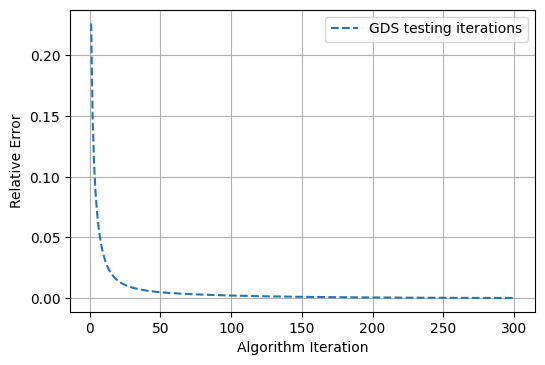

In [325]:
plt.figure(dpi=100)

plt.plot(range(1,tot_iter+1),errors_iter,'--',label=f'GDS testing iterations')
#plt.xlim(50,100)
#plt.ylim(0,0.1)
plt.ylabel('Relative Error')
plt.xlabel('Algorithm Iteration')
plt.grid()
plt.legend()

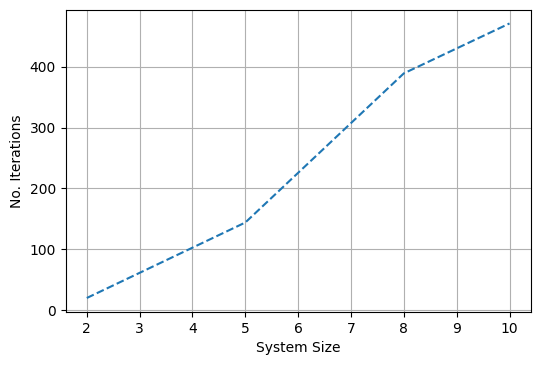

In [342]:
plt.figure(dpi=100)
plt.plot([2,5,8,10],[20,144,389,471],'--',)
#plt.xlim(50,100)
#plt.ylim(0,0.1)
plt.ylabel('No. Iterations')
plt.xlabel('System Size')
plt.grid()



# Testing Ansatz

In [127]:
iterations_GDS = 200
ansatz_list = ['up','right', 'random','right-large']
errors_GDS_ansatz = np.empty(shape=(len(ansatz_list),iterations_GDS))
for i,ansatz in enumerate(ansatz_list):
    errors_GDS_ansatz[i], psi_GDS = GDS_optimization(L=8,J=1.0,g=2.0, rate=0.01, ansatz=ansatz,iterations=iterations_GDS)

initial norm: 1.0
initial energy: -16.0


100%|██████████| 200/200 [00:01<00:00, 162.99it/s]


final bond dimensions:  [1, 1, 1, 1, 1, 1, 1, 1, 1]
final energy: -16.0
initial norm: 0.9999999999999988
initial energy: -6.999999999999991


100%|██████████| 200/200 [00:01<00:00, 169.56it/s]


final bond dimensions:  [1, 1, 1, 1, 1, 1, 1, 1, 1]
final energy: -15.954875623065488
initial norm: 5.3243526232080796e-06
initial energy: -3.4240173428055756


100%|██████████| 200/200 [00:02<00:00, 99.06it/s] 


final bond dimensions:  [1, 2, 4, 8, 16, 8, 4, 2, 1]
final energy: -16.7841225849016
initial norm: 0.9999999999999988
initial energy: -6.999999999999991


100%|██████████| 200/200 [00:02<00:00, 97.73it/s]

final bond dimensions:  [1, 2, 4, 8, 16, 8, 4, 2, 1]
final energy: -16.843890813782277


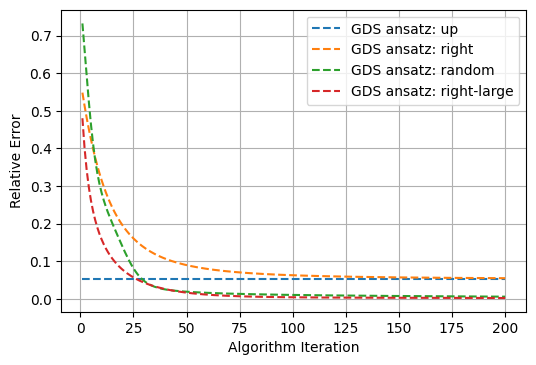

In [129]:
plt.figure(dpi=100)
for i,ansatz in enumerate(ansatz_list):
    plt.plot(range(1,iterations_GDS+1),errors_GDS_ansatz[i],'--',label=f'GDS ansatz: {ansatz_list[i]}')
#plt.xlim(50,100)
#plt.ylim(0,0.1)
plt.ylabel('Relative Error')
plt.xlabel('Algorithm Iteration')
plt.grid()
plt.legend()
plt.legend()

In [108]:
for i,ansatz in enumerate(ansatz_list):
    print(ansatz_list[i], min(errors_GDS_ansatz[i]), np.argmin(errors_GDS_ansatz[i]))

right 0.054267570364752174 199
up 0.05389573379346646 0
random 0.006949969543027539 199
right-large 0.0007435670884748289 199


In [140]:
def check_convergence(sequence:np.array, tol=1e-5):

   L = len(sequence)
   for i in range(L):
      diff = (sequence[i] - sequence[(i+1)%L])
      if diff<tol:
         print('diff: ',diff)
         print('index:', i)
         break 


In [141]:
check_convergence(errors_GDS_ansatz[-1])

diff:  9.991067712810178e-06
index: 176


# Note:
Main idea is that the energy expectation value was zero, which means that also the derivative would be zero. This is because the g here is zero

# Comparing with other implementations:

In [247]:
L = 2
J = 1.0
g = 1.5

# EXACT DIAGONALIZATION
model = TFIModel(L, J, g)
E_exact = finite_gs_energy(model.L, model.J, model.g)
print("Exact diagonalization: E = {E:.13f}".format(E=E_exact))

Exact diagonalization: E = -3.1622776601684


In [173]:
#GDS
iterations_GDS = 200
errors_GDS, psi_GDS = GDS_optimization(L=L,J=J,g=g, rate=0.05, ansatz=ansatz,iterations=iterations_GDS)

initial norm: 0.9999999999999984
initial energy: -8.999999999999986


100%|██████████| 200/200 [00:09<00:00, 21.06it/s]

final bond dimensions:  [1, 2, 4, 8, 16, 32, 16, 8, 4, 2, 1]
final energy: -16.53060983078578


In [174]:
min(errors_GDS)

0.00028092194455870534

In [232]:
# DMRG
iterations_DMRG = 10
errors_DMRG, psi_DMRG = DMRG(L=L,J=J,g=g,iterations=iterations_DMRG)

sweep  1: E = -16.5367276271275, rel. error 8.9063e-05
sweep  2: E = -16.5352549475329, rel. error 4.6795e-11
sweep  3: E = -16.5352549467592, rel. error 6.4457e-16
sweep  4: E = -16.5352549467592, rel. error 6.4457e-16
sweep  5: E = -16.5352549467592, rel. error 6.4457e-16
final bond dimensions:  [2, 4, 8, 16, 22, 16, 8, 4, 2]


In [179]:
#TEBD
iterations_TEBD = 100
errors_TEBD, psi_TEBD = TEBD_gs_finite(L=L, J=J, g=g, iterations=iterations_TEBD, dts_len=5) #5xN_steps =  iterations. funciton modified by me

finite TEBD, (imaginary time evolution)
L=10, J=1.0, g=1.50
dt = 0.10000: E = -16.4721433991333
dt = 0.01000: E = -16.5271745461962
dt = 0.00100: E = -16.5324766150975
dt = 0.00010: E = -16.5330081409660
dt = 0.00001: E = -16.5330613075609
final bond dimensions:  [2, 4, 8, 13, 15, 13, 8, 4, 2]


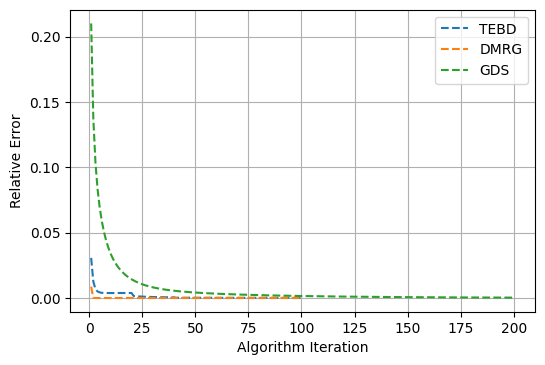

In [211]:
plt.figure(dpi=100)
plt.ylabel('Relative Error')
plt.xlabel('Algorithm Iteration')
plt.plot(range(1,iterations_TEBD+1),errors_TEBD,'--',label='TEBD')
plt.plot(range(1,iterations_DMRG+1),errors_DMRG,'--',markersize=2,label='DMRG')
plt.plot(range(1,iterations_GDS+1),errors_GDS,'--',label='GDS')
plt.legend()
plt.grid()
plt.show()

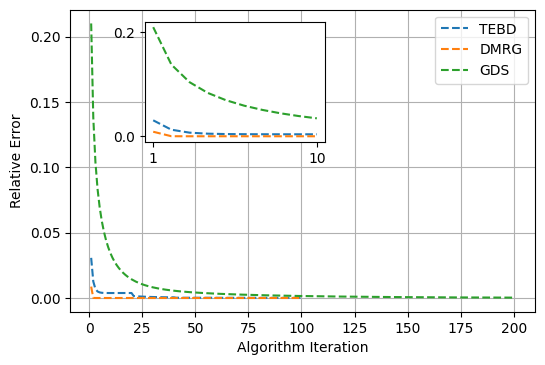

In [226]:
fig1 = plt.figure(dpi=100)
ax1 = fig1.add_subplot(111)
ax1.plot(range(1,iterations_TEBD+1),errors_TEBD,'--',label='TEBD')
ax1.plot(range(1,iterations_DMRG+1),errors_DMRG,'--',markersize=2,label='DMRG')
ax1.plot(range(1,iterations_GDS+1),errors_GDS,'--',label='GDS')

ax2 = plt.axes([.25, .55, .3, .3])
ax2.plot(range(1,iterations_TEBD+1)[:10],errors_TEBD[:10],'--')
ax2.plot(range(1,iterations_DMRG+1)[:10],errors_DMRG[:10],'--',markersize=2,label='DMRG')
ax2.plot(range(1,iterations_GDS+1)[:10],errors_GDS[:10],'--',label='GDS')
plt.setp(ax2, xticks=[1,10], yticks=[0,round(max(errors_GDS),1)])

ax1.legend()
ax1.set_ylabel('Relative Error')
ax1.set_xlabel('Algorithm Iteration')
ax1.grid()
plt.show()

# Different Set of Parameters:

In [156]:
gs = [0.5,1.0,1.2,1.5]
Ls= [2,5,8,10,16]

In [157]:
iterations_forlist = 200

cut_Ls = Ls[:4]

errorsGDS_array = np.empty(shape=(len(gs),len(cut_Ls),iterations_forlist))
psiGDS_array = np.empty(shape=(len(gs),len(cut_Ls)), dtype=MPS)

for i,g in enumerate(gs):
    print('g:', g)
    for j,L in enumerate(cut_Ls):
        print('L:', L)
        errorsGDS_array[i,j], psiGDS_array[i,j] = GDS_optimization(L=L,J=1.0,g=g, rate=0.05, iterations=iterations_forlist)

g: 0.5
L: 2
initial norm: 0.9999999999999997
initial energy: -0.9999999999999996


100%|██████████| 200/200 [00:00<00:00, 1237.98it/s]


final bond dimensions:  [1, 2, 1]
final energy: -1.4142069752389734
L: 5
initial norm: 0.9999999999999992
initial energy: -3.999999999999997


100%|██████████| 200/200 [00:00<00:00, 323.72it/s]


final bond dimensions:  [1, 2, 4, 4, 2, 1]
final energy: -4.445665777703457
L: 8
initial norm: 0.9999999999999988
initial energy: -6.999999999999991


100%|██████████| 200/200 [00:02<00:00, 92.09it/s]


final bond dimensions:  [1, 2, 4, 8, 16, 8, 4, 2, 1]
final energy: -7.636448815465964
L: 10
initial norm: 0.9999999999999984
initial energy: -8.999999999999986


100%|██████████| 200/200 [00:09<00:00, 20.90it/s]


final bond dimensions:  [1, 2, 4, 8, 16, 32, 16, 8, 4, 2, 1]
final energy: -9.763543941747796
g: 1.0
L: 2
initial norm: 0.9999999999999997
initial energy: -0.9999999999999996


100%|██████████| 200/200 [00:00<00:00, 1346.57it/s]


final bond dimensions:  [1, 2, 1]
final energy: -2.236067977499783
L: 5
initial norm: 0.9999999999999992
initial energy: -3.999999999999997


100%|██████████| 200/200 [00:00<00:00, 311.72it/s]


final bond dimensions:  [1, 2, 4, 4, 2, 1]
final energy: -6.014291791245949
L: 8
initial norm: 0.9999999999999988
initial energy: -6.999999999999991


100%|██████████| 200/200 [00:02<00:00, 98.85it/s]


final bond dimensions:  [1, 2, 4, 8, 16, 8, 4, 2, 1]
final energy: -9.774721576572839
L: 10
initial norm: 0.9999999999999984
initial energy: -8.999999999999984


100%|██████████| 200/200 [00:09<00:00, 21.20it/s]


final bond dimensions:  [1, 2, 4, 8, 16, 32, 16, 8, 4, 2, 1]
final energy: -12.299713568504771
g: 1.2
L: 2
initial norm: 0.9999999999999997
initial energy: -0.9999999999999996


100%|██████████| 200/200 [00:00<00:00, 1360.44it/s]


final bond dimensions:  [1, 2, 1]
final energy: -2.5999999999999988
L: 5
initial norm: 0.9999999999999992
initial energy: -3.999999999999997


100%|██████████| 200/200 [00:00<00:00, 325.21it/s]


final bond dimensions:  [1, 2, 4, 4, 2, 1]
final energy: -6.845103439343769
L: 8
initial norm: 0.9999999999999988
initial energy: -6.999999999999993


100%|██████████| 200/200 [00:02<00:00, 96.06it/s]


final bond dimensions:  [1, 2, 4, 8, 16, 8, 4, 2, 1]
final energy: -11.1006238451759
L: 10
initial norm: 0.9999999999999984
initial energy: -8.999999999999988


100%|██████████| 200/200 [00:09<00:00, 21.16it/s]


final bond dimensions:  [1, 2, 4, 8, 16, 32, 16, 8, 4, 2, 1]
final energy: -13.93898586888347
g: 1.5
L: 2
initial norm: 0.9999999999999997
initial energy: -0.9999999999999996


100%|██████████| 200/200 [00:00<00:00, 1348.90it/s]


final bond dimensions:  [1, 2, 1]
final energy: -3.1622776601683786
L: 5
initial norm: 0.9999999999999992
initial energy: -3.9999999999999964


100%|██████████| 200/200 [00:00<00:00, 327.05it/s]


final bond dimensions:  [1, 2, 4, 4, 2, 1]
final energy: -8.171436564630339
L: 8
initial norm: 0.9999999999999988
initial energy: -6.999999999999991


100%|██████████| 200/200 [00:02<00:00, 97.21it/s]


final bond dimensions:  [1, 2, 4, 8, 16, 8, 4, 2, 1]
final energy: -13.186529767764714
L: 10
initial norm: 0.9999999999999984
initial energy: -8.999999999999986


100%|██████████| 200/200 [00:09<00:00, 20.71it/s]

final bond dimensions:  [1, 2, 4, 8, 16, 32, 16, 8, 4, 2, 1]
final energy: -16.53060983078578


In [158]:
errorsGDS_array.shape

(4, 4, 200)

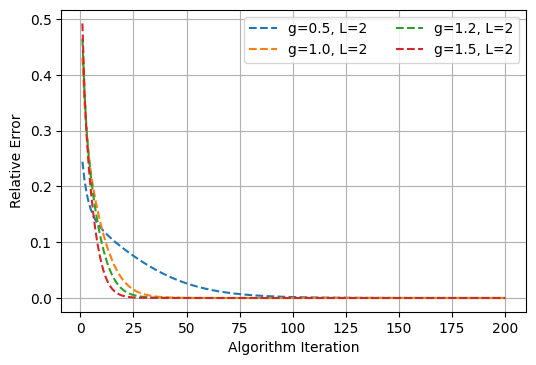

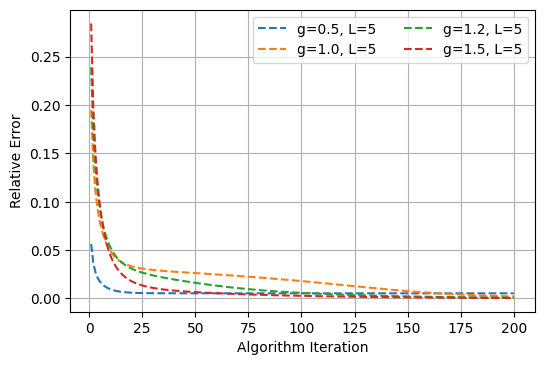

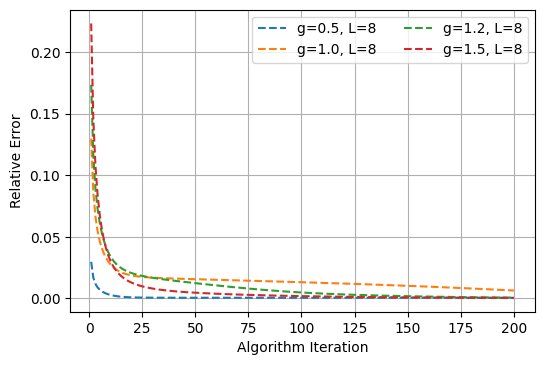

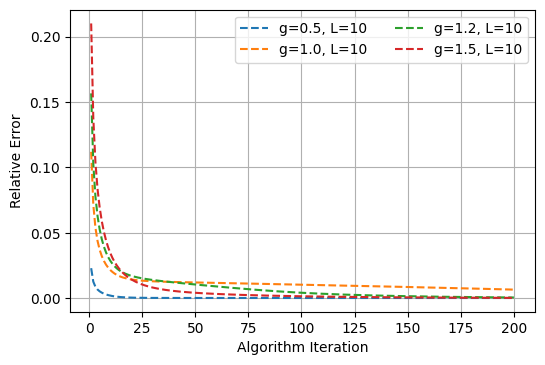

In [163]:


ls = '--'
for j, L in enumerate(cut_Ls):
    plt.figure(dpi=100)
    plt.ylabel('Relative Error')
    plt.xlabel('Algorithm Iteration')
    for i, g in enumerate(gs):
        #if g == 1.5:
        #    ls = 'x'
        #else:
        #    ls = '-'
        plt.plot(range(1,iterations_forlist+1), errorsGDS_array[i,j,:], ls,label=f'g={g}, L={L}')
    plt.legend(loc='best',ncol=2)
    plt.grid()
    plt.show()

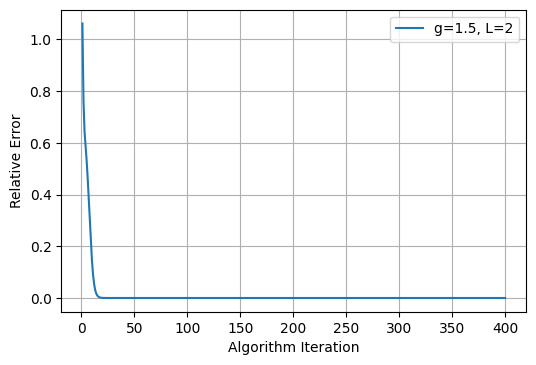

In [142]:
Lcheck_index = 0
gcheck_index = 4
plt.figure(dpi=100)
plt.ylabel('Relative Error')
plt.xlabel('Algorithm Iteration')
#plt.xlim(left=100,right=201)
#plt.ylim(top=0.002)
plt.plot(range(1,iterations_forlist+1), errorsGDS_array[gcheck_index,Lcheck_index,:], label=f'g={gs[gcheck_index]}, L={Ls[Lcheck_index]}')
plt.legend()
plt.grid()
plt.show()

In [160]:
for j in range(len(gs)):
    print('g:', gs[j])
    for i in range(len(cut_Ls)):
        print('L:', Ls[i], 'min: ', min(errorsGDS_array[j,i,:]))

g: 0.5
L: 2 min:  4.65780720605073e-06
L: 5 min:  0.005330488370767968
L: 8 min:  0.0005423320370830758
L: 10 min:  0.00020070814448831909
g: 1.0
L: 2 min:  2.9790409838967273e-15
L: 5 min:  0.002054597894236059
L: 8 min:  0.006427137928487397
L: 10 min:  0.006604732641407853
g: 1.2
L: 2 min:  0.0
L: 5 min:  0.000742217729729488
L: 8 min:  0.0006833520985598323
L: 10 min:  0.0005989779165854836
g: 1.5
L: 2 min:  0.0
L: 5 min:  0.0005198723503773132
L: 8 min:  0.0003695727969730469
L: 10 min:  0.00028092194455462424


# Learning rate parameter:

In [148]:
iterations_rates = 200

#rates = [2] + [10**(-i) for i in range(4)]

rates = [1.0,0.1,0.05,0.025,0.01]

L_rate = 5
g_rate = 1.5
errorsGDS_rates = np.empty(shape=(len(rates),iterations_rates))
psiGDS_rates = np.empty(shape=(len(rates)), dtype=MPS)


for i,r in enumerate(rates):
    print('rate:', r)
    errorsGDS_rates[i], psiGDS_rates[i] = GDS_optimization(L=L_rate,J=1.0,g=g_rate, rate=r, iterations=iterations_rates)

rate: 1.0
initial norm: 0.9999999999999992
initial energy: -3.9999999999999964


100%|██████████| 200/200 [00:00<00:00, 327.95it/s]


final bond dimensions:  [1, 2, 4, 4, 2, 1]
final energy: -3.3762217511770656
rate: 0.1
initial norm: 0.9999999999999992
initial energy: -3.9999999999999964


100%|██████████| 200/200 [00:00<00:00, 301.48it/s]


final bond dimensions:  [1, 2, 4, 4, 2, 1]
final energy: -8.175540113688402
rate: 0.05
initial norm: 0.9999999999999992
initial energy: -3.9999999999999964


100%|██████████| 200/200 [00:00<00:00, 331.06it/s]


final bond dimensions:  [1, 2, 4, 4, 2, 1]
final energy: -8.171436564630339
rate: 0.025
initial norm: 0.9999999999999992
initial energy: -3.9999999999999964


100%|██████████| 200/200 [00:00<00:00, 331.46it/s]


final bond dimensions:  [1, 2, 4, 4, 2, 1]
final energy: -8.153147758625076
rate: 0.01
initial norm: 0.9999999999999992
initial energy: -3.9999999999999964


100%|██████████| 200/200 [00:00<00:00, 333.24it/s]

final bond dimensions:  [1, 2, 4, 4, 2, 1]
final energy: -8.107194520985491


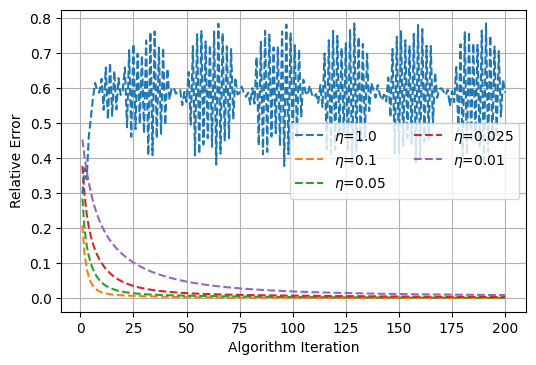

In [149]:
plt.figure(dpi=100)
plt.ylabel('Relative Error')
plt.xlabel('Algorithm Iteration')

#plt.title('Relative error of GDS for L={} and g={}'.format(L_rate, g_rate))
for i,r in enumerate(rates):
        plt.plot(range(1,iterations_rates+1), errorsGDS_rates[i,:],'--',markersize=0.75,label=rf'$\eta$={r}')
plt.legend(loc='best',ncol=2)
plt.grid()
plt.show()

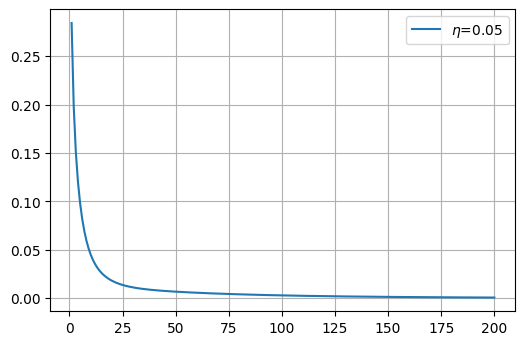

In [152]:
rtest_index = 2
r = rates[rtest_index]
plt.figure(dpi=100)
plt.plot(range(1,iterations_rates+1), errorsGDS_rates[rtest_index,:],label=rf'$\eta$={r}')
plt.legend(loc='best',ncol=2)
plt.grid()
plt.show()

In [153]:
for i in range(len(rates)):
    print(rf'$\eta$ :', rates[i],'min: ',min(errorsGDS_rates[i,:]))

$\eta$ : 1.0 min:  0.2968473844193814
$\eta$ : 0.1 min:  1.795133515225836e-05
$\eta$ : 0.05 min:  0.0005198723503788334
$\eta$ : 0.025 min:  0.0027568472098321315
$\eta$ : 0.01 min:  0.008377566095507223


# for L = 16

In [179]:
iterations_L16 = 200
gs16 = [0.5,1.0,1.2,1.5]
errorsGDS_L16 = np.empty(shape=(len(gs16), iterations_L16))
psiGDS_L16 = np.empty(shape=(len(gs16)), dtype=MPS)

for i,g in tqdm(enumerate(gs16)):
    print('g:', g)
    #errorsGDS_L16[i], psiGDS_L16[i] = GDS_optimization(L=16,J=1.0,g=g, rate=0.05, iterations=iterations_L16)

0it [00:00, ?it/s]

g: 0.5
initial energy: 1.505663213054134


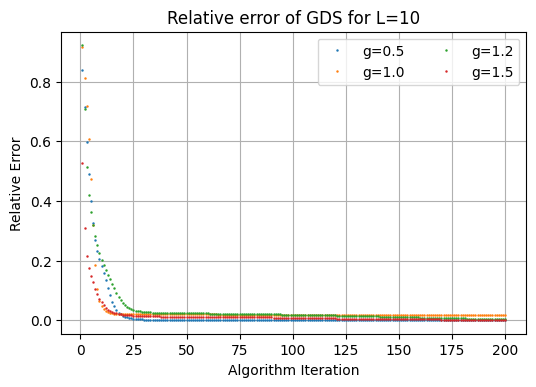

In [178]:
plt.figure(dpi=100)
plt.ylabel('Relative Error')
plt.xlabel('Algorithm Iteration')

plt.title('Relative error of GDS for L={}'.format(10))
for i,g in enumerate(gs16):
        plt.plot(range(1,iterations_L16+1), errorsGDS_L16[i,:],'o',markersize=0.75,label=rf'g={g}')
plt.legend(loc='best',ncol=2)
plt.grid()
plt.show()

In [174]:
for i in range(len(gs16)):
    print(rf'g :', gs16[i],'min: ',min(errorsGDS_L16[i,:]))

g : 0.5 min:  0.0006105032746138546
g : 1.0 min:  0.015712891356227058
g : 1.2 min:  0.003651881146833842
g : 1.5 min:  0.0012674930935228082


# Random, individual tests:

In [ ]:
psi = init_spinup_MPS(2)
H = TFIModel(2,1,0)
psi.Bs[0][0][0], psi.Bs[1][0][0] = 2,2
inner_product(psi) #16
H.energy(psi) #-32.0
mps_orthonormalize_left(psi.Bs) #left normalize in place
inner_product(psi) #1.0
H.energy(psi) #-2.0
np.tensordot(psi.Bs[0],psi.Bs[0].conj(),axes=((0,1),(0,1))) #checking if the vector were left normalized

array([[1.]])

In [ ]:
H = TFIModel(2,1,2)
psi_test = init_spinup_MPS(L=2)
M0 = psi_test.Bs[0]
print(M0[:,0,:]) # 0th: 1 (spin up), 1st: 0 (spin down)

print(H.H_mpo[0][0,0,:,:]) #first row and first column of big matrix, showing all in the remaining two dimensions corresponding to the local basis

print(H.H_mpo[1].shape) #vL vR ket bra

print(psi_test.Bs[0][0,:,0]) #vl i vR: Pick first dimension on vL and vR. from this we can see that the tensor itself has a vector form on the local dimension.

[[1.]]
[[1. 0.]
 [0. 1.]]
(3, 1, 2, 2)
[1. 0.]


In [ ]:
H.H_bonds[0].reshape(4,4)

array([[-4., -0., -0., -1.],
       [-0.,  0., -1.,  0.],
       [-0., -1.,  0.,  0.],
       [-1.,  0.,  0.,  4.]])

In [ ]:
H.H_mpo

[array([[[[ 1.,  0.],
          [ 0.,  1.]],
 
         [[ 0.,  1.],
          [ 1.,  0.]],
 
         [[-2.,  0.],
          [ 0.,  2.]]]]),
 array([[[[-2.,  0.],
          [ 0.,  2.]]],
 
 
        [[[ 0., -1.],
          [-1.,  0.]]],
 
 
        [[[ 1.,  0.],
          [ 0.,  1.]]]])]

## own implementation of MPO hamiltonian:

In [ ]:
class TLS:

    def zero(self):
        return np.array([1,0])

    def one(self):
        return np.array([0,1])
        
    def X(self):
        return np.array([[0,1],[1,0]])

    def Z(self):
        return np.array([[1,0],[0,-1]])

    def Y(self):
        return np.array([[0,-1j],[1j,0]])

    def I(self):
        return np.eye(2)

tls = TLS()
X = tls.X()
Y = tls.Y()
Z = tls.Z()
I = tls.I()

In [ ]:
#checking my result for g=2 J=1 and L=2
(2*np.kron(I,Z) + np.kron(X,X) + 2*np.kron(Z,I))

array([[ 4.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 1.,  0.,  0., -4.]])

In [ ]:
def construct_ising_hamiltonian_mpo(J, g, L, pbc=False):
    """
    Construct Ising Hamiltonian on a 1D lattice with `L` sites as MPO,
    for interaction parameter `J` and external field parameter `g`.

    output: 
    list of A[j] tensors corresponding to the MPO of the given Hamiltonian
    A[0] = [-gX -JZ  I2]


    A[L-1] = [I2 Z -gX].T (python does not distinguish between row and column vecetors)

    shape of each of the MPOS:
    i, j, vL, vR
    """
    Zero = np.zeros(shape=(2,2))      

    A1 = np.array([-g*X, -J*Z, I]) # shape = 3,2,2
    A1 = np.reshape(A1, newshape=(1,3,2,2))
    A1 = np.transpose(A1, axes=(2,3,0,1))
    A = [A1]
    print(A1.shape)

    Aj = np.array([[I, Zero, Zero],[Z, Zero, Zero],[-g*X, -J*Z, I]])
    print(Aj.shape)
    Aj = np.transpose(Aj, axes=(2,3,0,1)) #does not change the array in place but creates a view
    print(Aj.shape)
    for i in range(L-2):
        A.append(Aj)

    AL = np.array([I, Z, -g*X]) # shape = 3,2,2
    AL = np.reshape(AL, newshape=(3,1,2,2))
    AL = np.transpose(AL, axes=(2,3,0,1))
    print(AL.shape)
    A.append(AL)

    return A

In [ ]:
MPO_list = construct_ising_hamiltonian_mpo(0, 1, 3, pbc=False)

(2, 2, 1, 3)
(3, 3, 2, 2)
(2, 2, 3, 3)
(2, 2, 3, 1)


In [ ]:
for M in MPO_list:
    print(M.shape)

(2, 2, 1, 3)
(2, 2, 3, 3)
(2, 2, 3, 1)


In [ ]:
test = np.array([[[1]]])
test.shape

(1, 1, 1)

In [ ]:
test[0,0,0]

1

In [ ]:
np.array([[1,1,1]]).shape

(1, 3)

In [58]:
init_spinright_MPS(4).Bs[0]#[0,:,0] #shape 1,2,1

array([[[0.70710678],
        [0.70710678]]])